In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, solve
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
import time

In [3]:
def load_data(file_name_matrix='tfidf_matrix_97MB.npz', file_name_feature_names='feature_names_97MB.npy',
	      file_name_labels='train_labels.npy', samples_in_train_set=10000,
	      samples_in_test_set=137562):
	# Recuperation des donnees
	TF_IDF_matrix = sp.load_npz(file_name_matrix)
	TF_IDF_feature_names = np.load(file_name_feature_names)
	train_labels = np.load(file_name_labels, allow_pickle=True)
	train_labels_numeric = ((train_labels == 'Oui') + 0)

	X = TF_IDF_matrix[:samples_in_train_set].toarray()
	y = train_labels_numeric[:samples_in_train_set] * 2 - 1

	X_test = TF_IDF_matrix[samples_in_train_set:samples_in_train_set+samples_in_test_set].toarray()
	y_test = train_labels_numeric[samples_in_train_set:samples_in_train_set+samples_in_test_set] * 2 - 1


	# Standardisation des données
	std_X = np.maximum(np.std(X, axis=0), 1e-7)
	X = X / std_X
	X_test = X_test / std_X

	n = X.shape[0]
	n_test = X_test.shape[0]
	m = X.shape[1]

	# Ajout d'une colonne de uns
	eX = np.hstack((np.ones((n,1)), X))
	eX_test = np.hstack((np.ones((n_test,1)), X_test))

	return eX, y, eX_test, y_test

Get Data

In [4]:
X,y,X_test,y_test=load_data()
n,p=X.shape
print(X.shape)
print(y.shape)

(10000, 576)
(10000,)


Definition of f, f gradient and Hessian matrix, check by check_grad.

In [5]:
def f(w):
    rho=1/n
    sum=0
    for i in range(n):
        sum+=(1/n)*np.log(1+np.exp(-y[i]*(np.dot(X[i].T,w))))
    sum+=rho*np.square(np.linalg.norm(w,ord=2))/2
    return sum
	
def f_grad(w):
    rho=1/n
    v=np.zeros(p)
    v[0]=w[0]
    sum=0
    for i in range(n):
        si=y[i]*(np.dot(X[i].T,w))
        sum+=(1/n)*(-y[i]*X[i].T)/(1+np.exp(si))
    sum+=rho*(w-v)
    return sum

def f_h(w):
	rho=1/n
	sum=0
	for i in range(n):
		si=y[i]*np.dot(X[i].T,w)
		sum+=(1/n)*np.outer(X[i].T,X[i])*np.exp(si)/np.square((1+np.exp(si)))
	sum+=rho*np.eye(p)
	return sum

In [11]:
print(check_grad(f,f_grad,np.random.rand(p)))
print(check_grad(lambda x: f_grad(x)[0], lambda x: f_h(x)[:,0], np.random.rand(p)))

6.985081487577773e-05
0.00010000154936072056


check convex

In [12]:
V=np.linalg.eigvals(f_h(np.random.rand(p)))
if np.all(V>0): 
    print("convex")

convex


Definition of Newton's method

In [13]:
def newton(w, max_iter=100,eps=1e-10):
	wn=w
	norm_grad,values=[],[]
	norm=np.linalg.norm(f_grad(w),2)
	norm_grad.append(norm)
	n=0
	while(norm>eps) & (n<max_iter):
		grad=f_grad(wn)
		hess=f_h(wn)
		d=np.dot(np.linalg.inv(hess),grad)
		wn-=d
		norm=np.linalg.norm(f_grad(w),2)
		norm_grad.append(norm)
		values.append(f(w))
		n+=1
	return wn,norm_grad,values

Run Newton's method with w all 0

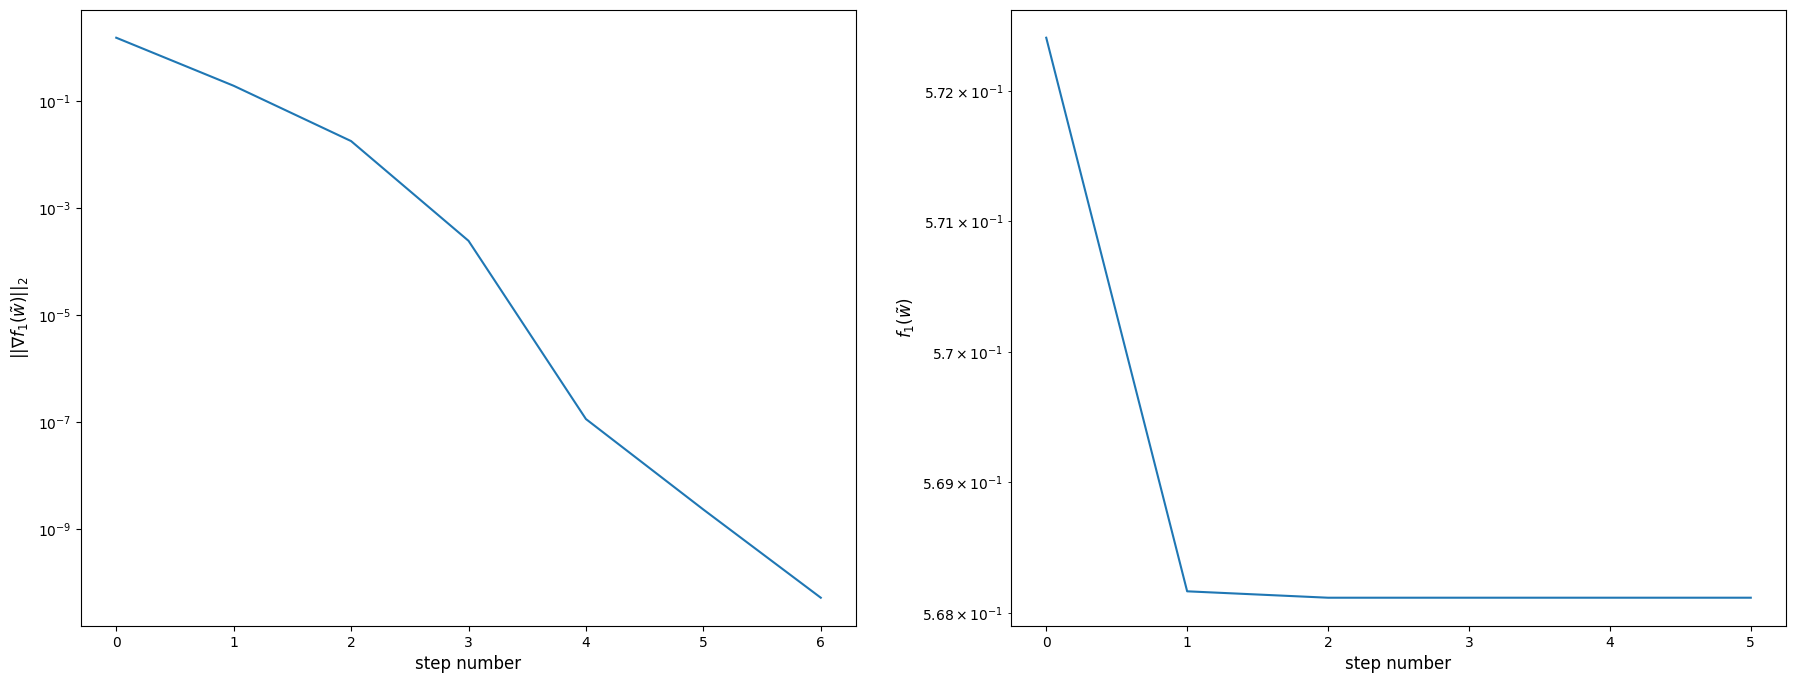

[-1.01121150e+00 -1.69547675e-02  2.38224484e-02 -3.36967544e-02
  5.50425751e-02  4.37308870e-02  3.93812382e-02  4.41541210e-02
  4.23164623e-03  1.19362378e-02  2.35070597e-02 -9.72047257e-03
  1.55294864e-02  3.79051462e-02  5.92445206e-02 -7.99751965e-03
  2.90120535e-02  1.26809331e-02  4.84062506e-02  6.00495264e-02
  4.31771541e-02 -2.61937885e-02 -1.03735527e-02 -5.20007224e-03
  1.54090649e-02  1.20867650e-02 -1.84972928e-03  3.73061778e-02
  2.34540888e-02  3.12764035e-02  1.31337349e-02  4.47206140e-02
  5.09964560e-02  5.23834108e-02  1.72671911e-02 -9.74809768e-02
  1.52593878e-02  1.01282400e-02  6.51855612e-02  3.82924006e-02
 -1.89448735e-02 -5.73778686e-02 -1.07126533e-02  1.82071708e-02
  1.28823691e-02  3.85071683e-02  6.43283887e-02  1.74271117e-02
 -2.61201469e-02 -1.82812504e-03  3.25045001e-02  2.62719150e-03
 -3.40369353e-02  2.05187209e-02 -2.34998303e-02 -1.18374699e-02
  9.33131042e-02  9.17186816e-02  7.89900225e-02  2.50093042e-02
 -2.63228522e-02 -7.21225

In [14]:
wn,norm_grad,values=newton(np.zeros(p),max_iter=10)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))

ax0.plot(norm_grad)
ax0.set_yscale("log")
ax0.set_xlabel("step number", fontsize=12)
ax0.set_ylabel(r"$\|\| \nabla f_1(\tilde{w}) \|\|_2$", fontsize=12)

ax1.plot(values)
ax1.set_yscale("log")
ax1.set_xlabel("step number", fontsize=12)
ax1.set_ylabel(r"$f_1(\tilde{w})$", fontsize=12)

plt.show()

print(wn)
print(f(wn))

Run Newton's method with w all 1

But this can lead to many errors, like overflow and invalid value

And it doesn't work for random w, just work for w around 0

C:\Users\13175\AppData\Local\Temp\ipykernel_4388\3412841704.py:25: RuntimeWarning: overflow encountered in square
  sum+=(1/n)*np.outer(X[i].T,X[i])*np.exp(si)/np.square((1+np.exp(si)))
C:\Users\13175\AppData\Local\Temp\ipykernel_4388\3412841704.py:16: RuntimeWarning: overflow encountered in exp
  sum+=(1/n)*(-y[i]*X[i].T)/(1+np.exp(si))
C:\Users\13175\AppData\Local\Temp\ipykernel_4388\3412841704.py:5: RuntimeWarning: overflow encountered in exp
  sum+=(1/n)*np.log(1+np.exp(-y[i]*(np.dot(X[i].T,w))))
C:\Users\13175\AppData\Local\Temp\ipykernel_4388\3412841704.py:25: RuntimeWarning: overflow encountered in exp
  sum+=(1/n)*np.outer(X[i].T,X[i])*np.exp(si)/np.square((1+np.exp(si)))
C:\Users\13175\AppData\Local\Temp\ipykernel_4388\3412841704.py:25: RuntimeWarning: invalid value encountered in multiply
  sum+=(1/n)*np.outer(X[i].T,X[i])*np.exp(si)/np.square((1+np.exp(si)))
C:\Users\13175\AppData\Local\Temp\ipykernel_4388\3412841704.py:25: RuntimeWarning: invalid value encountered in divide

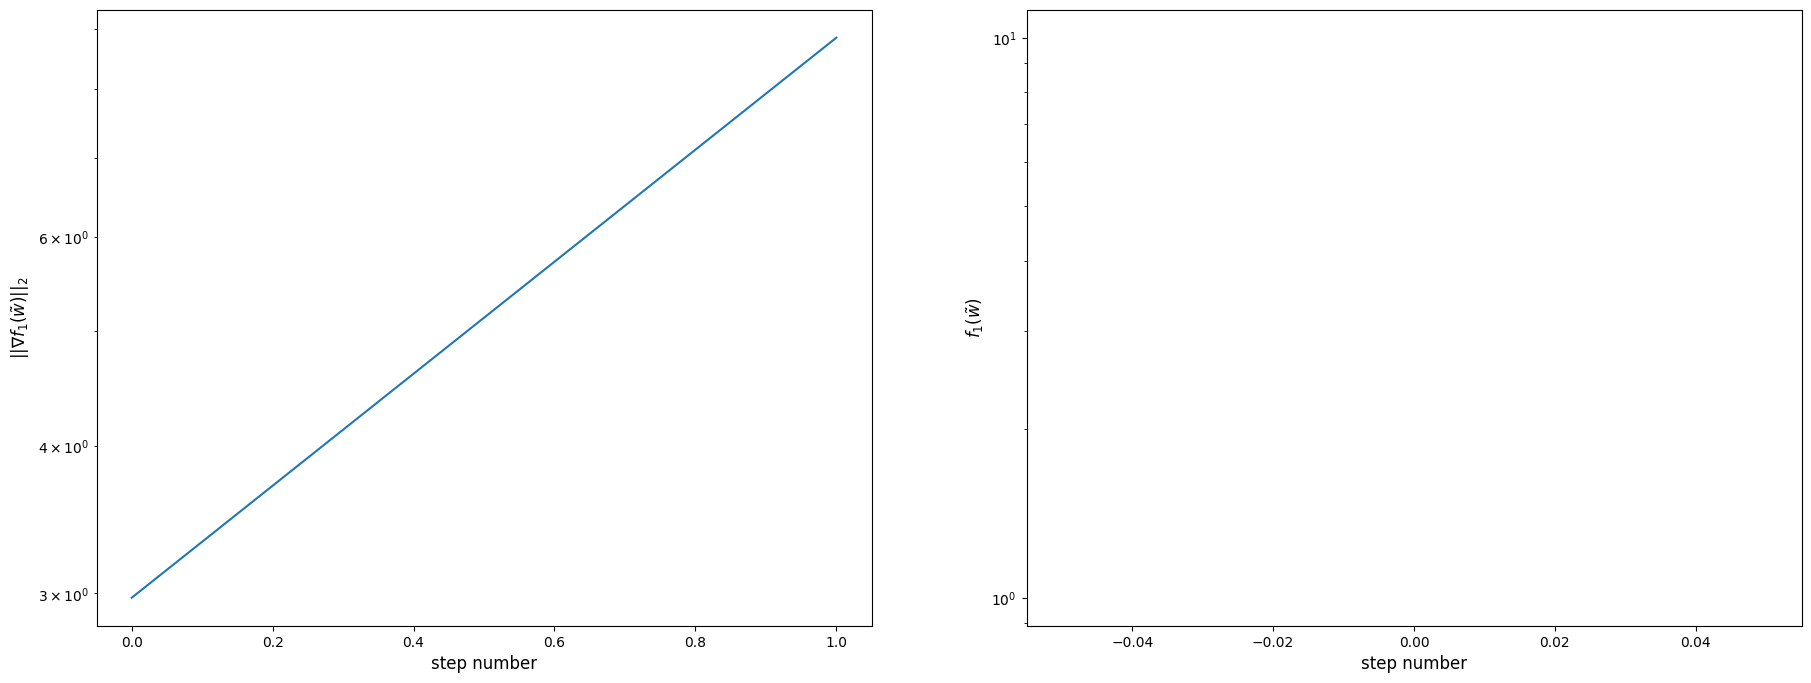

nan


In [18]:
wn,norm_grad,values=newton(np.full(p,1.),max_iter=10)


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))

ax0.plot(norm_grad)
ax0.set_yscale("log")
ax0.set_xlabel("step number", fontsize=12)
ax0.set_ylabel(r"$\|\| \nabla f_1(\tilde{w}) \|\|_2$", fontsize=12)

ax1.plot(values)
ax1.set_yscale("log")
ax1.set_xlabel("step number", fontsize=12)
ax1.set_ylabel(r"$f_1(\tilde{w})$", fontsize=12)

plt.show()

print(f(wn))